<a href="https://colab.research.google.com/github/fromrang/data-analysis/blob/master/analysis_practice/dog_cat_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 데이터 불러와서 저장하기

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

68616192/68606236 [==============================] - 0s 0us/step


# 디스크에 있는 데이터 가지고 오기

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


In [ ]:
# 

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


# 모델 만들기

In [ ]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160,160, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 64)       

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/10
63/63 [==============================] - 59s 929ms/step - loss: 0.6844 - accuracy: 0.5640 - val_loss: 0.6236 - val_accuracy: 0.6240
Epoch 2/10
63/63 [==============================] - 53s 841ms/step - loss: 0.5948 - accuracy: 0.6860 - val_loss: 0.6128 - val_accuracy: 0.6690
Epoch 3/10
63/63 [==============================] - 52s 830ms/step - loss: 0.5103 - accuracy: 0.7520 - val_loss: 0.5793 - val_accuracy: 0.7200
Epoch 4/10
63/63 [==============================] - 52s 832ms/step - loss: 0.4473 - accuracy: 0.7985 - val_loss: 0.5661 - val_accuracy: 0.7280
Epoch 5/10
63/63 [==============================] - 52s 826ms/step - loss: 0.3772 - accuracy: 0.8330 - val_loss: 0.5894 - val_accuracy: 0.7200
Epoch 6/10
63/63 [==============================] - 52s 830ms/step - loss: 0.2602 - accuracy: 0.8915 - val_loss: 0.6634 - val_accuracy: 0.7040
Epoch 7/10
63/63 [==============================] - 52s 829ms/step - loss: 0.1728 - accuracy: 0.9335 - val_loss: 0.7543 - val_accuracy: 0.7230

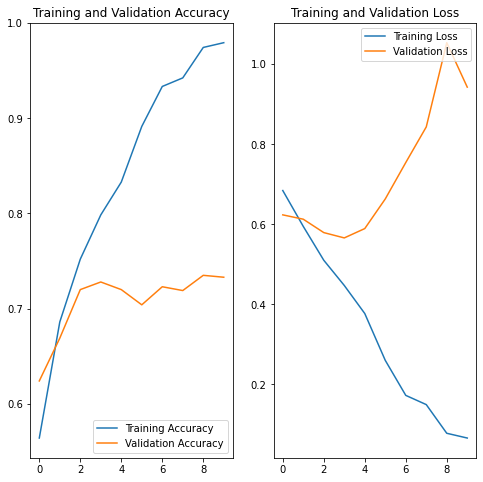

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 과대적합 문제점 발견 모델 수정

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(160, 
                                                              160,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/15
63/63 [==============================] - 63s 978ms/step - loss: 0.7213 - accuracy: 0.5350 - val_loss: 0.6934 - val_accuracy: 0.5190
Epoch 2/15
63/63 [==============================] - 60s 953ms/step - loss: 0.6863 - accuracy: 0.5475 - val_loss: 0.6555 - val_accuracy: 0.5970
Epoch 3/15
63/63 [==============================] - 61s 969ms/step - loss: 0.6565 - accuracy: 0.6245 - val_loss: 0.6580 - val_accuracy: 0.5920
Epoch 4/15
63/63 [==============================] - 59s 945ms/step - loss: 0.6448 - accuracy: 0.6310 - val_loss: 0.6255 - val_accuracy: 0.6340
Epoch 5/15
63/63 [==============================] - 59s 946ms/step - loss: 0.6061 - accuracy: 0.6810 - val_loss: 0.6367 - val_accuracy: 0.6370
Epoch 6/15
63/63 [==============================] - 59s 944ms/step - loss: 0.5940 - accuracy: 0.6865 - val_loss: 0.5811 - val_accuracy: 0.6850
Epoch 7/15
63/63 [==============================] - 60s 955ms/step - loss: 0.5789 - accuracy: 0.6990 - val_loss: 0.5758 - val_accuracy: 0.6880

#두번째 훈련 결과 시각화

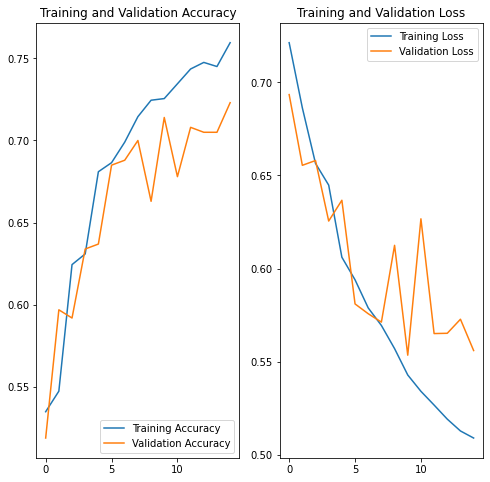

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 새로운 이미지 가지고 와서 모델 테스트

In [ ]:
dog_image_url = 'https://mypetlife.co.kr/9989/kakaotalk_20180720_165306472/'
dog_image_path = tf.keras.utils.get_file('dog_dog_image', origin = dog_image_url)

img = keras.preprocessing.image.load_img(
    dog_image_path, target_size=(160, 160)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

90112/77123 [===================================] - 0s 2us/step
This image most likely belongs to dogs with a 60.19 percent confidence.
